Find the compliance rate per day per participant
====

In [1]:
"""
Read in the smartwatch data

Throw away catchups since we don't care about them here

"""
from ema import clean

meal_info = clean.cleaned_smartwatch(keep_catchups=False)

/home/mh19137/seaco_malaysia/ema/clean.py:189: UserWarning: Long catchup: not marking Meal at 2022-05-19 09:02:49 as catchup
  warnings.warn(


 Open ended catchup at 2022-02-11 20:02:05 ended by No response at 2022-02-12 08:02:11
 Open ended catchup at 2022-02-14 20:26:30 ended by No response at 2022-02-15 08:02:16
 Open ended catchup at 2022-04-19 08:01:14 ended by No catch-up at 2022-04-19 08:01:17
 Open ended catchup at 2022-06-27 15:53:14 ended by Catch-up start at 2022-06-27 15:54:06
 Open ended catchup at 2021-12-31 22:11:10 ended by No catch-up at 2022-01-01 08:01:15
 Open ended catchup at 2022-05-24 07:25:36 ended by Catch-up start at 2022-05-24 07:26:00
 Open ended catchup at 2022-03-21 08:01:57 ended by No catch-up at 2022-03-21 08:02:04
 Open ended catchup at 2022-03-07 18:33:30 ended by No catch-up at 2022-03-07 18:33:34
 Open ended catchup at 2022-03-07 18:37:08 ended by No catch-up at 2022-03-07 18:37:14
 Open ended catchup at 2022-03-07 19:29:23 ended by No response at 2022-03-08 08:02:56
 Open ended catchup at 2022-03-08 08:30:40 ended by No catch-up at 2022-03-08 08:31:08
 Open ended catchup at 2022-03-08 09:

In [2]:
"""
Collapse entries into a bool

"""
meal_info["entry"] = meal_info["meal_type"].isin(
    {"Meal", "Drink", "Snack", "No food/drink"}
)

In [3]:
"""
Group the entries by participant and time - two entries are marked as the same if they are by the same user and within 5 minutes of each other

"""
import numpy as np
import pandas as pd


def collapse_meal_info(meal_df: pd.DataFrame, delta: pd.Timedelta) -> pd.DataFrame:
    collapsed_meal_info = pd.DataFrame()

    for p_id, group in meal_df.groupby("p_id"):
        assert group.index.is_monotonic_increasing

        # Mark which ones are near enough each other to be considered the same
        n_entries = len(group)
        keep = np.ones(n_entries, dtype=bool)

        for i in range(1, n_entries):
            if (group.index[i] - group.index[i - 1] < delta) and (
                group["entry"].iloc[i] == group["entry"].iloc[i - 1]
            ):
                keep[i] = False

        # Append to the new dataframe
        collapsed_meal_info = pd.concat([collapsed_meal_info, group[keep]])

    return collapsed_meal_info

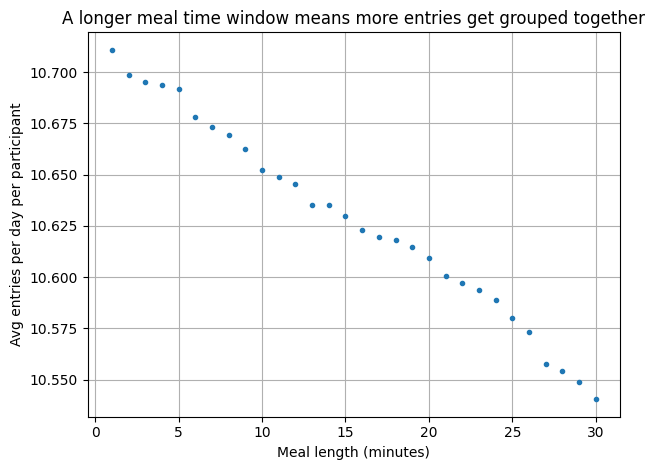

In [4]:
"""
Experiment with the length of time, seeing how the length of time affects the number of entries in our dataframe

"""
import os
import matplotlib.pyplot as plt

deltas = pd.timedelta_range(start="1min", end="30min", freq="1min")

# Number of entries per day per participant
lens = [
    len(collapse_meal_info(meal_info, delta)) / (7 * meal_info["p_id"].unique().size)
    for delta in deltas
]

fig, axis = plt.subplots()
axis.plot(deltas.total_seconds() / 60, lens, ".")
axis.grid("on")

axis.set_xlabel("Meal length (minutes)")
axis.set_ylabel("Avg entries per day per participant")
axis.set_title("A longer meal time window means more entries get grouped together")

img_dir = "img/compliance"
if not os.path.isdir(img_dir):
    os.mkdir(img_dir)

fig.tight_layout()
fig.savefig(f"{img_dir}/window_width.png")

It looks like there's no clear point where we should consider entries part of the same meal (5 minutes might be a good candidate?) - so as part of the analysis we can just try several different values and see how much of a difference it makes.

We'll choose a 5 minute window for now

In [5]:
"""
Histogram of the number of entries per day per participant

"""
delta = pd.Timedelta("5min")

collapsed_meal_info = collapse_meal_info(meal_info, delta)

# Group by days
collapsed_meal_info["delta_day"] = collapsed_meal_info["delta"].dt.days

n_participants, n_days = len(collapsed_meal_info["p_id"].unique()), 7

# Find how many entries each participant made on each day
n_entries = np.zeros((n_participants, n_days), dtype=int)
n_positive = np.zeros((n_participants, n_days), dtype=int)
for i, (p_id, group) in enumerate(collapsed_meal_info.groupby("p_id")):
    for j, (delta, subgroup) in enumerate(group.groupby("delta_day")):
        n_entries[i, j] = len(subgroup["entry"])
        n_positive[i, j] = subgroup["entry"].sum()

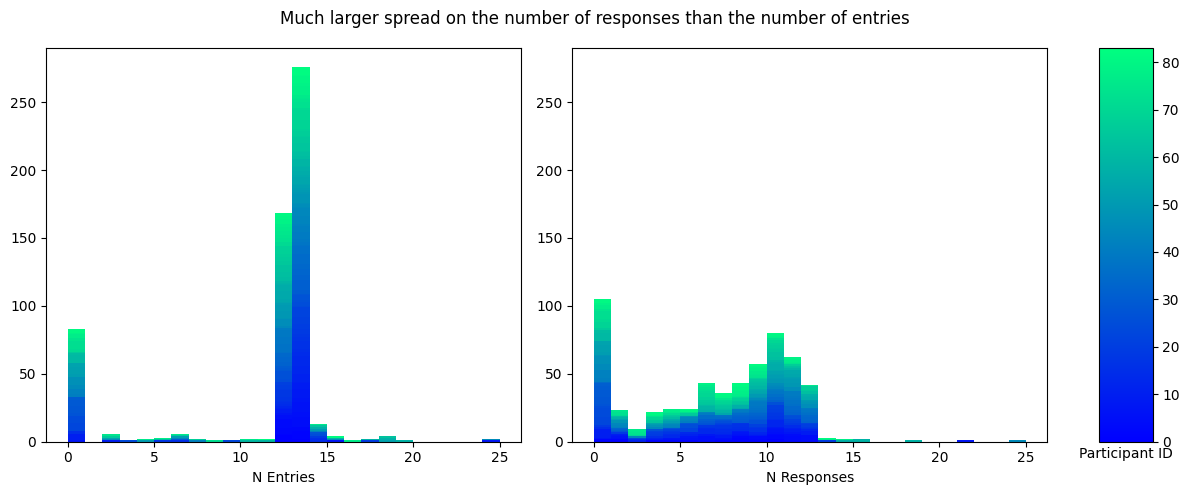

In [6]:
"""
Plot a histogram of the number of entries per participant

"""
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

fig, axes = plt.subplot_mosaic(
    """
    AAAAABBBBBC
    AAAAABBBBBC
    AAAAABBBBBC
    AAAAABBBBBC
    AAAAABBBBBC
    """,
    figsize=(12, 5),
)

bins = np.linspace(0, 25, 26)
cmap = plt.get_cmap("winter")
colours = [cmap(i / n_entries.shape[0]) for i in range(n_entries.shape[0])]

axes["A"].hist(n_entries.T, stacked=True, bins=bins, color=colours)
axes["B"].hist(n_positive.T, stacked=True, bins=bins, color=colours)

axes["A"].set_xlabel("N Entries")
axes["B"].set_xlabel("N Responses")
fig.colorbar(
    cax=axes["C"],
    mappable=ScalarMappable(cmap=cmap, norm=Normalize(0, n_entries.shape[0])),
)

axes["B"].set_ylim(axes["A"].get_ylim())

axes["C"].set_xlabel("Participant ID")

fig.suptitle("Much larger spread on the number of responses than the number of entries")
fig.tight_layout()

fig.savefig(f"{img_dir}/n_entries_participant.png")

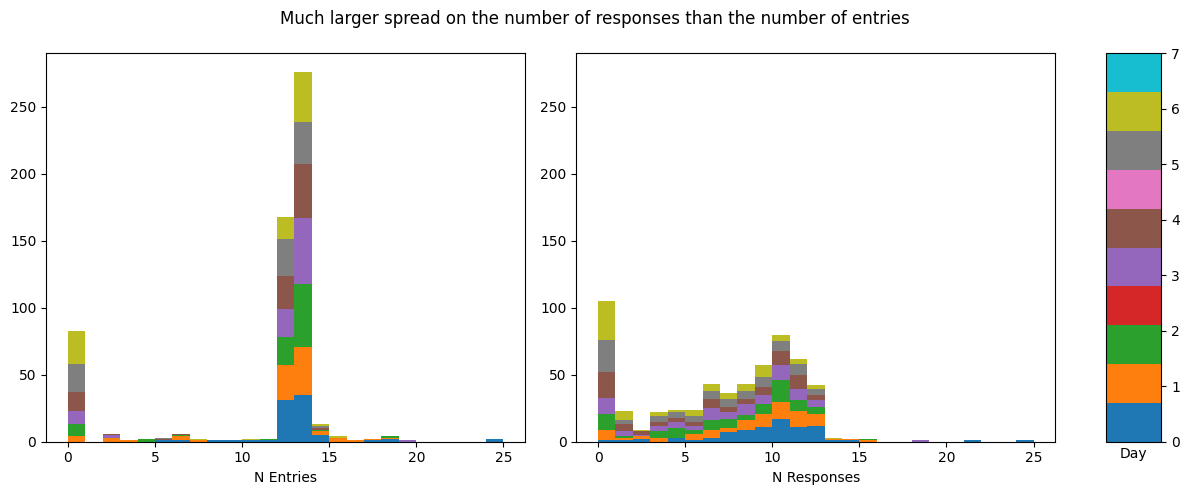

In [7]:
"""
Do it again colouring by day

"""

fig, axes = plt.subplot_mosaic(
    """
    AAAAABBBBBC
    AAAAABBBBBC
    AAAAABBBBBC
    AAAAABBBBBC
    AAAAABBBBBC
    """,
    figsize=(12, 5),
)

cmap = plt.get_cmap("tab10")
colours = [cmap(i / n_entries.shape[1]) for i in range(n_entries.shape[1])]

axes["A"].hist(n_entries, stacked=True, bins=bins, color=colours)
axes["B"].hist(n_positive, stacked=True, bins=bins, color=colours)

axes["A"].set_xlabel("N Entries")
axes["B"].set_xlabel("N Responses")
fig.colorbar(
    cax=axes["C"],
    mappable=ScalarMappable(cmap=cmap, norm=Normalize(0, n_entries.shape[1])),
)

axes["B"].set_ylim(axes["A"].get_ylim())

axes["C"].set_xlabel("Day")

fig.suptitle("Much larger spread on the number of responses than the number of entries")
fig.tight_layout()

fig.savefig(f"{img_dir}/n_entries_day.png")

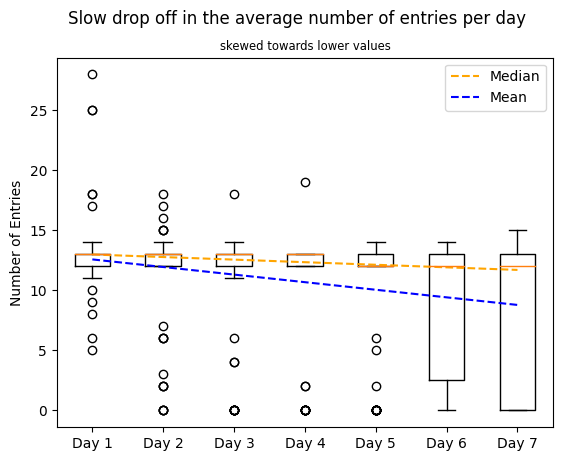

In [10]:
"""
Average number of entries per day

"""
# Assuming n_entries is your 7x83 numpy array
n_participants, n_days = n_entries.shape

# Create a list of entries for each day
entries_per_day = [n_entries[:, i] for i in range(n_days)]

# Create a list of day labels
d = np.arange(1, 8, 1)
days = ["Day {}".format(i) for i in d]

# Create the boxplot
fig, axis = plt.subplots()

axis.boxplot(entries_per_day, labels=days)

# Plot medians and means
median_vals = np.polyval(
    np.polyfit(
        np.arange(0, n_days, 1),
        [np.median(entries) for entries in entries_per_day],
        1,
    ),
    d,
)
axis.plot(d, median_vals, "--", label="Median", color="orange")

# Plot means
mean_vals = np.polyval(
    np.polyfit(
        np.arange(1, n_days + 1, 1),
        [np.mean(entries) for entries in entries_per_day],
        1,
    ),
    d,
)
axis.plot(d, mean_vals, "b--", label="Mean")

fig.suptitle("Slow drop off in the average number of entries per day")
axis.set_title("skewed towards lower values", fontsize="small")
axis.set_ylabel("Number of Entries")

axis.legend()
fig.savefig(f"{img_dir}/n_entries_day_boxplot.png")